In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

# Initial setup

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
x_train, x_valid = x_train / 255.0, x_valid / 255.0

In [5]:
x_mean, x_std = x_train.mean(), x_valid.std()
x_train = normalize(x_train, x_mean, x_std)
x_valid = normalize(x_valid, x_mean, x_std)

In [6]:
n,m = x_train.shape
n,m

(60000, 784)

In [7]:
c = y_train.max() + 1
nh = 50

In [8]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [9]:
model = Model(m, nh, 10)

In [10]:
pred = model(x_train)

In [11]:
pred.shape

torch.Size([60000, 10])

In [12]:
pred.exp().sum(-1, keepdim=True).shape

torch.Size([60000, 1])

# Cross entropy loss

In [13]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [14]:
sm_pred = log_softmax(pred)

In [18]:
sm_pred.shape

torch.Size([60000, 10])

In [15]:
y_train[:3]

tensor([4, 4, 4])

In [16]:
sm_pred[[0,1,2], [4,4,4]]

tensor([-2.5736, -2.7045, -2.7718], grad_fn=<IndexBackward>)

In [17]:
y_train.shape

torch.Size([60000])

In [19]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [22]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3500, grad_fn=<NegBackward>)

In [23]:
def log_softmax(x): return x - x.exp().sum(-1, keepdims=True).log()

In [25]:
test_near(nll(log_softmax(pred), y_train), loss)

In [26]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:,None]).exp().sum(-1).log()

In [27]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [28]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [29]:
test_near(F.cross_entropy(pred, y_train), loss)

In [35]:
loss_func = F.cross_entropy

In [36]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1) == yb).float().mean()

In [37]:
bs = 64
xb = x_train[:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.4044, -0.3926, -0.0080,  0.1982, -0.2072,  0.3303, -0.0063, -0.1152,
         -0.1788,  0.2988], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [38]:
yb = y_train[:bs]
loss_func(preds, yb)

tensor(2.6893, grad_fn=<NllLossBackward>)

In [39]:
accuracy(preds, yb)

tensor(0.)

In [40]:
preds.argmax(1)

tensor([0, 0, 6, 5, 9, 5, 5, 5, 5, 5, 9, 0, 0, 9, 0, 5, 5, 0, 0, 5, 0, 9, 0, 0,
        9, 0, 5, 9, 5, 5, 0, 0, 5, 5, 5, 5, 0, 5, 5, 5, 5, 0, 0, 3, 0, 9, 5, 9,
        9, 5, 9, 0, 0, 9, 5, 5, 0, 5, 9, 0, 9, 5, 0, 0])

In [41]:
yb

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [44]:
lr = 0.5
epochs = 1

In [45]:
n

60000

In [46]:
n // bs 

937

In [47]:
937 * bs

59968

In [50]:
model()

Model()

In [48]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= lr * l.weight.grad
                    l.bias -= lr * l.bias.grad
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [49]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(1.1755e-05, grad_fn=<NllLossBackward>), tensor(1.))

## Using parameters and optim

In [53]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))    

In [54]:
model = Model(m, nh, 10)

In [56]:
for name, l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [57]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [58]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [59]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= lr * p.grad
                model.zero_grad()

In [60]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0., grad_fn=<NllLossBackward>), tensor(1.))

In [71]:
xb.shape # 32, because its the last minibatch of the batch and has not 64 entries!

torch.Size([32, 784])

In [76]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [77]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [79]:
mdl.l1

Linear(in_features=784, out_features=50, bias=True)

In [82]:
mdl._modules

{'l1': Linear(in_features=784, out_features=50, bias=True),
 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [78]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registering modules

In [83]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [84]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [85]:
model = Model(layers)

In [86]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.ModuleList

In [89]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [90]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [92]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0193, grad_fn=<NllLossBackward>), tensor(1.))

In [93]:
yb

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

In [95]:
torch.argmax(model(xb), -1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

## nn.Sequential

In [97]:
model = nn.Sequential(*layers)

In [98]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0192, grad_fn=<NllLossBackward>), tensor(1.))

In [100]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

# optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```



and instead use just:


```python
opt.step()
opt.zero_grad()
```

In [103]:
class Optimizer():
    def __init__(self, params, lr=0.5): 
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= lr * p.grad
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [104]:
model = nn.Sequential(*layers)

In [107]:
opt = Optimizer(model.parameters())

In [108]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [110]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(8.4632e-05, grad_fn=<NllLossBackward>), tensor(1.))

In [111]:
#export
from torch import optim

In [113]:
# optim.SGD.step??

In [185]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [189]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [119]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2747, grad_fn=<NllLossBackward>)

In [120]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [121]:
loss, acc = loss_func(model(xb),yb), accuracy(model(xb),yb)
loss, acc

(tensor(0., grad_fn=<NllLossBackward>), tensor(1.))

In [122]:
assert acc > 0.7

# Dataset and DataLoader

## Dataset

In [123]:
#export 
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
        
    def __len__(self): return len(self.x)
    
    def __getitem__(self, i): return self.x[i], self.y[i]

In [125]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [127]:
xb, yb = train_ds[:5]
assert xb.shape == (5,28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[-0.4208, -0.4208, -0.4208,  ..., -0.4208, -0.4208, -0.4208],
         [-0.4208, -0.4208, -0.4208,  ..., -0.4208, -0.4208, -0.4208],
         [-0.4208, -0.4208, -0.4208,  ..., -0.4208, -0.4208, -0.4208],
         [-0.4208, -0.4208, -0.4208,  ..., -0.4208, -0.4208, -0.4208],
         [-0.4208, -0.4208, -0.4208,  ..., -0.4208, -0.4208, -0.4208]]),
 tensor([4, 4, 4, 4, 4]))

In [128]:
model, opt = get_model()

In [130]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i*bs : i*bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [139]:
#export
def loss_and_accuracy(model=model, xb=xb, yb=yb):
    return loss_func(model(xb), yb), accuracy(model(xb),yb)

In [142]:
loss, acc = loss_and_accuracy()
assert acc > 0.7
loss, acc

(tensor(0.0195, grad_fn=<NllLossBackward>), tensor(1.))

## DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [176]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [177]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [178]:
xb, yb = next(iter(train_dl))

In [179]:
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

tensor(4)

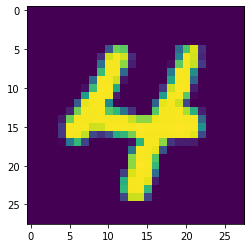

In [182]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [190]:
model, opt = get_model()

In [191]:
loss_and_accuracy()

(tensor(0.0195, grad_fn=<NllLossBackward>), tensor(1.))

In [192]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred,yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [198]:
fit()

In [199]:
loss_and_accuracy()

(tensor(0.0195, grad_fn=<NllLossBackward>), tensor(1.))

In [200]:
assert acc > 0.7

## Random Sampling

In [201]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs):
            yield self.idxs[i:i+self.bs]

In [202]:
small_ds = Dataset(*train_ds[:10])

In [203]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [204]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([3, 4, 2]), tensor([6, 1, 7]), tensor([9, 5, 0]), tensor([8])]

In [208]:
# next(iter(train_ds))

In [209]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [218]:
train_samp = Sampler(train_ds, bs, True)
valid_samp = Sampler(valid_ds, bs, False)

In [219]:
train_dl = DataLoader(train_ds, train_samp, collate)
valid_dl = DataLoader(valid_ds, valid_samp, collate)

tensor(0)

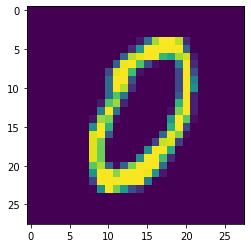

In [224]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(9)

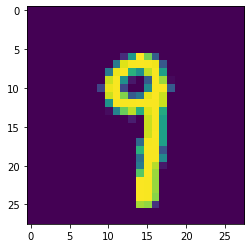

In [225]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [226]:
model, opt = get_model()
fit()

loss_and_accuracy()

(tensor(0.0195, grad_fn=<NllLossBackward>), tensor(1.))

## PyTorch DataLoader

In [227]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [228]:
train_dl = DataLoader(train_ds, bs, RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, SequentialSampler(valid_ds), collate_fn=collate)

In [229]:
model, opt = get_model()
fit()
loss_and_accuracy()

(tensor(0.0195, grad_fn=<NllLossBackward>), tensor(1.))

In [230]:
train_dl = DataLoader(train_ds, bs, True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, False)

In [231]:
model, opt = get_model()
fit()
loss_and_accuracy()

(tensor(0.0195, grad_fn=<NllLossBackward>), tensor(1.))

# Validation

In [232]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        # print model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        # print model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [233]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, True, **kwargs), DataLoader(valid_ds, 2*bs, **kwargs))

In [235]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.3133) tensor(0.9169)
1 tensor(0.2866) tensor(0.9291)
2 tensor(0.2532) tensor(0.9372)
3 tensor(0.3014) tensor(0.9266)
4 tensor(0.2387) tensor(0.9423)


In [236]:
assert acc > 0.9

# Export

In [237]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
